In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Interactive plotting
%matplotlib widget

plt.style.use("ggplot")

# Estimate river fluxes

Taking clean river discharge data (output of notebook q2_clean_discharge_data) and estimated daily concentrations of the variables of interest (from notebook flux2). Multiply these together (taking care of the units) to estimate daily, monthly and annual fluxes to the Oslofjord from the three big rivers.

**Discuss with Helene how to save the results.** E.g. one csv per river of daily fluxes?

Also plot daily, monthly and annual fluxes

## Read in

In [2]:
df_water_chem = pd.read_csv('../../data/river/water_chem/estimations/water_chem_daily_estimations.csv')
df_water_chem

station_name        Date  discharge  Farge_mg Pt/l_raw  \
0      Drammenselva v/Krokstadelva  1990-01-01    264.681                NaN   
1      Drammenselva v/Krokstadelva  1990-01-02    264.681                NaN   
2      Drammenselva v/Krokstadelva  1990-01-03    260.214                NaN   
3      Drammenselva v/Krokstadelva  1990-01-04    260.214                NaN   
4      Drammenselva v/Krokstadelva  1990-01-05    260.214                NaN   
...                            ...         ...        ...                ...   
37969          Numedalslågen v/E18  2024-08-23    155.641                NaN   
37970          Numedalslågen v/E18  2024-08-24    199.478                NaN   
37971          Numedalslågen v/E18  2024-08-25    213.277                NaN   
37972          Numedalslågen v/E18  2024-08-26    192.718                NaN   
37973          Numedalslågen v/E18  2024-08-27    148.680                NaN   

       Farge_mg Pt/l_est  DIN_μg/l_raw  DIN_μg/l_est  PO4-P_µg/l_raw  \
0                    NaN           NaN           NaN             NaN   
1                    NaN           NaN           NaN             NaN   
2                    NaN           NaN           NaN             NaN   
3                    NaN           NaN           NaN             NaN   
4                    NaN           NaN           NaN             NaN   
...                  ...           ...           ...             ...   
37969               37.0           NaN         155.0             NaN   
37970               37.0           NaN         155.0             NaN   
37971               37.0           NaN         155.0             NaN   
37972               37.0           NaN         155.0             NaN   
37973               37.0           NaN         155.0             NaN   

       PO4-P_µg/l_est  SiO2_mg/l_raw  ...  TOTP_P_µg/l P_raw  \
0                 NaN            NaN  ...                NaN   
1                 NaN            NaN  ...                NaN   
2                 NaN            NaN  ...                NaN   
3                 NaN            NaN  ...                NaN   
4                 NaN            NaN  ...                NaN   
...               ...            ...  ...                ...   
37969             2.0            NaN  ...                NaN   
37970             2.0            NaN  ...                NaN   
37971             2.0            NaN  ...                NaN   
37972             2.0            NaN  ...                NaN   
37973             2.0            NaN  ...                NaN   

       TOTP_P_µg/l P_est  TOTP_µg/l_raw  TOTP_µg/l_est  TSM_mg/l_raw  \
0                    NaN            NaN            NaN           NaN   
1                    NaN            NaN            NaN           NaN   
2                    NaN            NaN            NaN           NaN   
3                    NaN            NaN            NaN           NaN   
4                    NaN            NaN            NaN           NaN   
...                  ...            ...            ...           ...   
37969                6.6            NaN            7.8           NaN   
37970                6.6            NaN            7.8           NaN   
37971                6.6            NaN            7.8           NaN   
37972                6.6            NaN            7.8           NaN   
37973                6.6            NaN            7.8           NaN   

       TSM_mg/l_est  UV-Abs. 410nm_Abs/cm_raw  UV-Abs. 410nm_Abs/cm_est  \
0               NaN                       NaN                       NaN   
1               NaN                       NaN                       NaN   
2               NaN                       NaN                       NaN   
3               NaN                       NaN                       NaN   
4               NaN                       NaN                       NaN   
...             ...                       ...                       ...   
37969          2.91                  

In [3]:
df_drammen = df_water_chem[df_water_chem['station_name'] == 'Drammenselva v/Krokstadelva'].copy()
df_glomma = df_water_chem[df_water_chem['station_name'] == 'Glomma v/Sarpefossen'].copy()
df_numed = df_water_chem[df_water_chem['station_name'] == 'Numedalslågen v/E18' ].copy()

variables = ['DIN_μg/l_raw', 'DIN_μg/l_est', 'PO4-P_µg/l_raw',
             'PO4-P_µg/l_est', 'SiO2_mg/l_raw', 'SiO2_mg/l_est', 'TOC_mg/l_raw',
             'TOC_mg/l_est', 'TOTN_µg/l_raw', 'TOTN_µg/l_est', 'TOTP/F_µg/l P_raw',
             'TOTP/F_µg/l P_est', 'TOTP_P_µg/l P_raw', 'TOTP_P_µg/l P_est',
             'TOTP_µg/l_raw', 'TOTP_µg/l_est', 'TSM_mg/l_raw', 'TSM_mg/l_est']

## Estimate fluxes

### Daily fluxes

In [4]:
def compute_fluxes(df):
   
    flux_data = {}

    metadata_cols = ['Date', 'station_name']  
    for col in metadata_cols:
        if col in df.columns:
            flux_data[col] = df[col]

    for var in variables:
        flux_col = var + '_flux'
        flux_values = []

        for index, row in df.iterrows():
            discharge = row['discharge'] * 86400  # m³/s to m³/day
            concentration = row[var]

            # Handle NaNs
            if pd.isna(concentration) or pd.isna(discharge):
                flux_values.append(None)
                continue

            # Convert concentration to kg/m³
            if 'mg/l' in var:
                concentration_kg_per_m3 = concentration * 1e-3
            elif 'μg/l' in var or 'µg/l' in var:
                concentration_kg_per_m3 = concentration * 1e-6
            else:
                raise ValueError(f"Unknown unit in variable name: {var}")

            # Compute flux
            flux_kg_day = concentration_kg_per_m3 * discharge
            flux_tonnes_day = flux_kg_day / 1000

            flux_values.append(flux_tonnes_day)

        flux_data[flux_col] = flux_values

    fluxes_df = pd.DataFrame(flux_data)
    return fluxes_df


In [5]:
# Compute the fluxes for each river separately
drammen_fluxes = compute_fluxes(df_drammen)
glomma_fluxes = compute_fluxes(df_glomma)
numed_fluxes = compute_fluxes(df_numed)

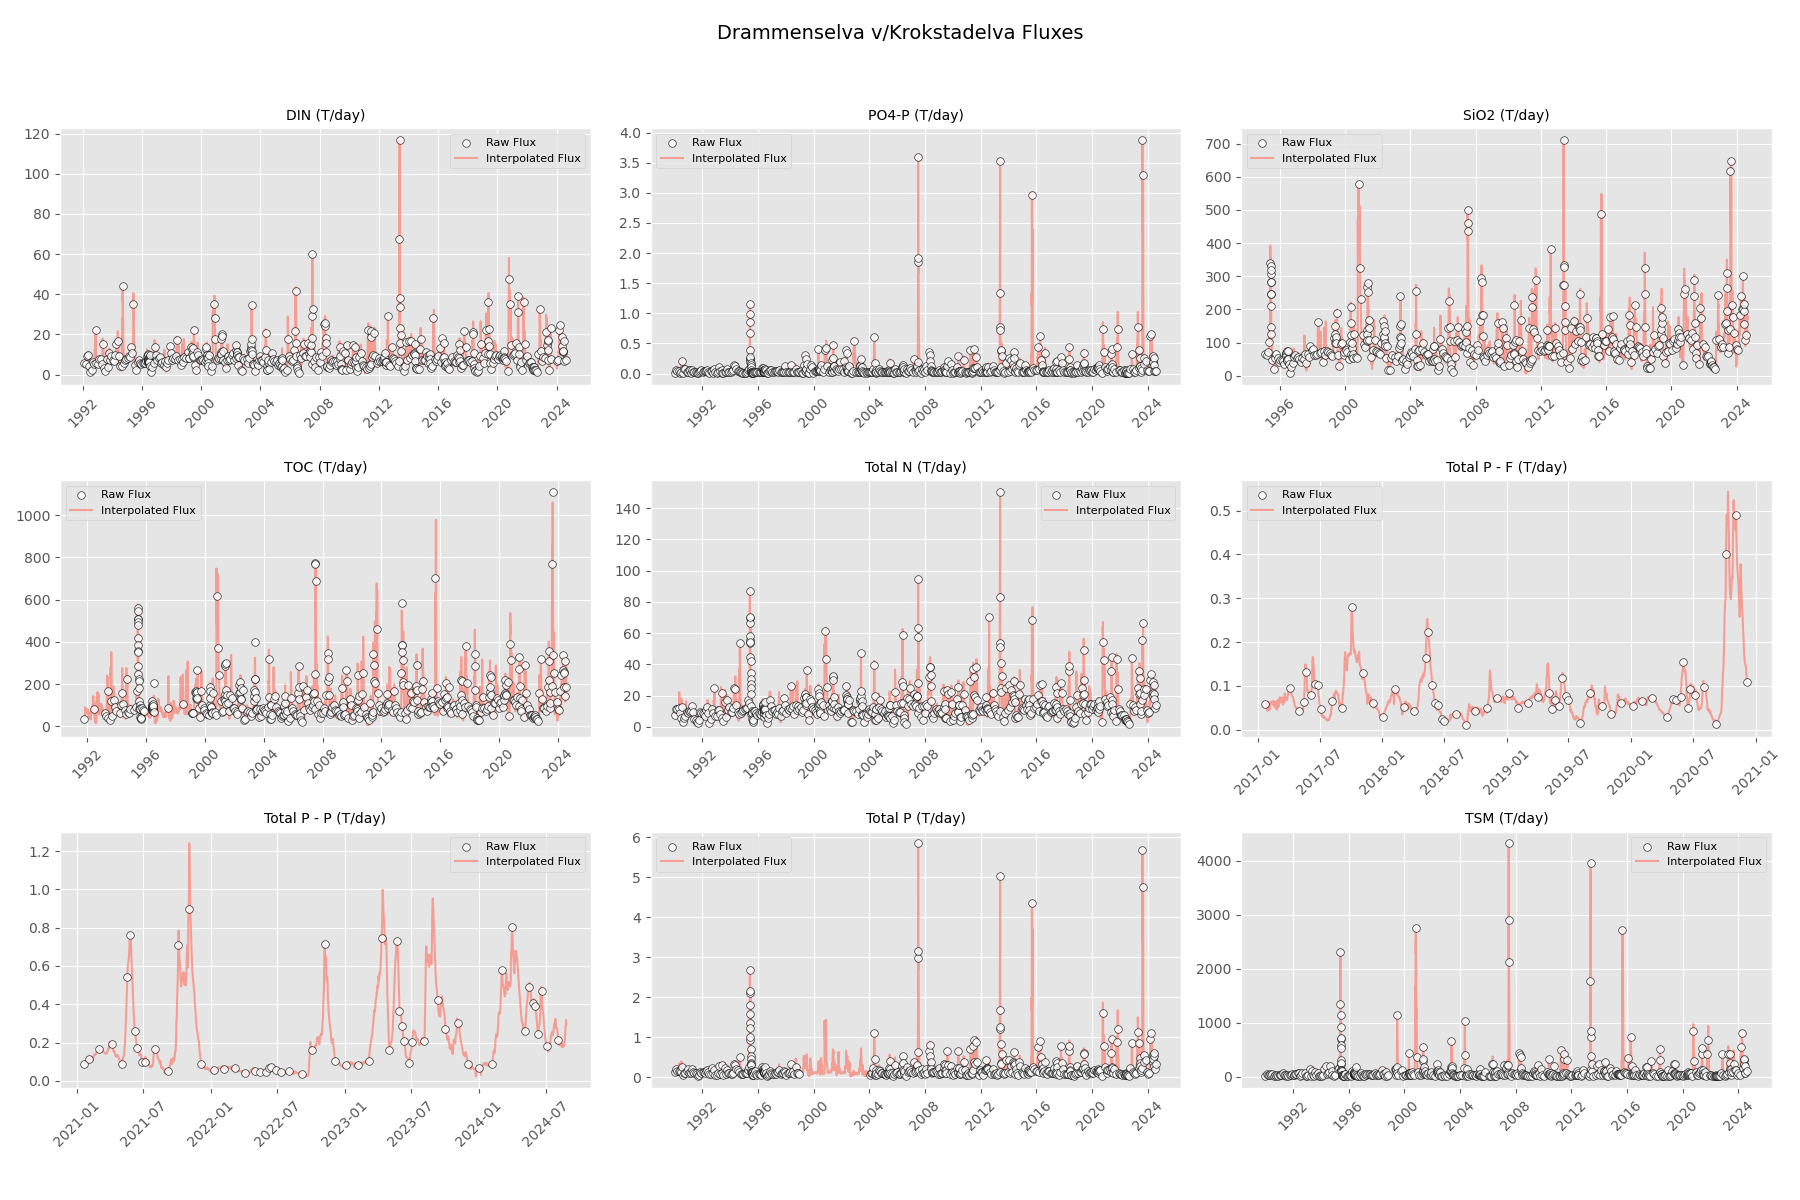

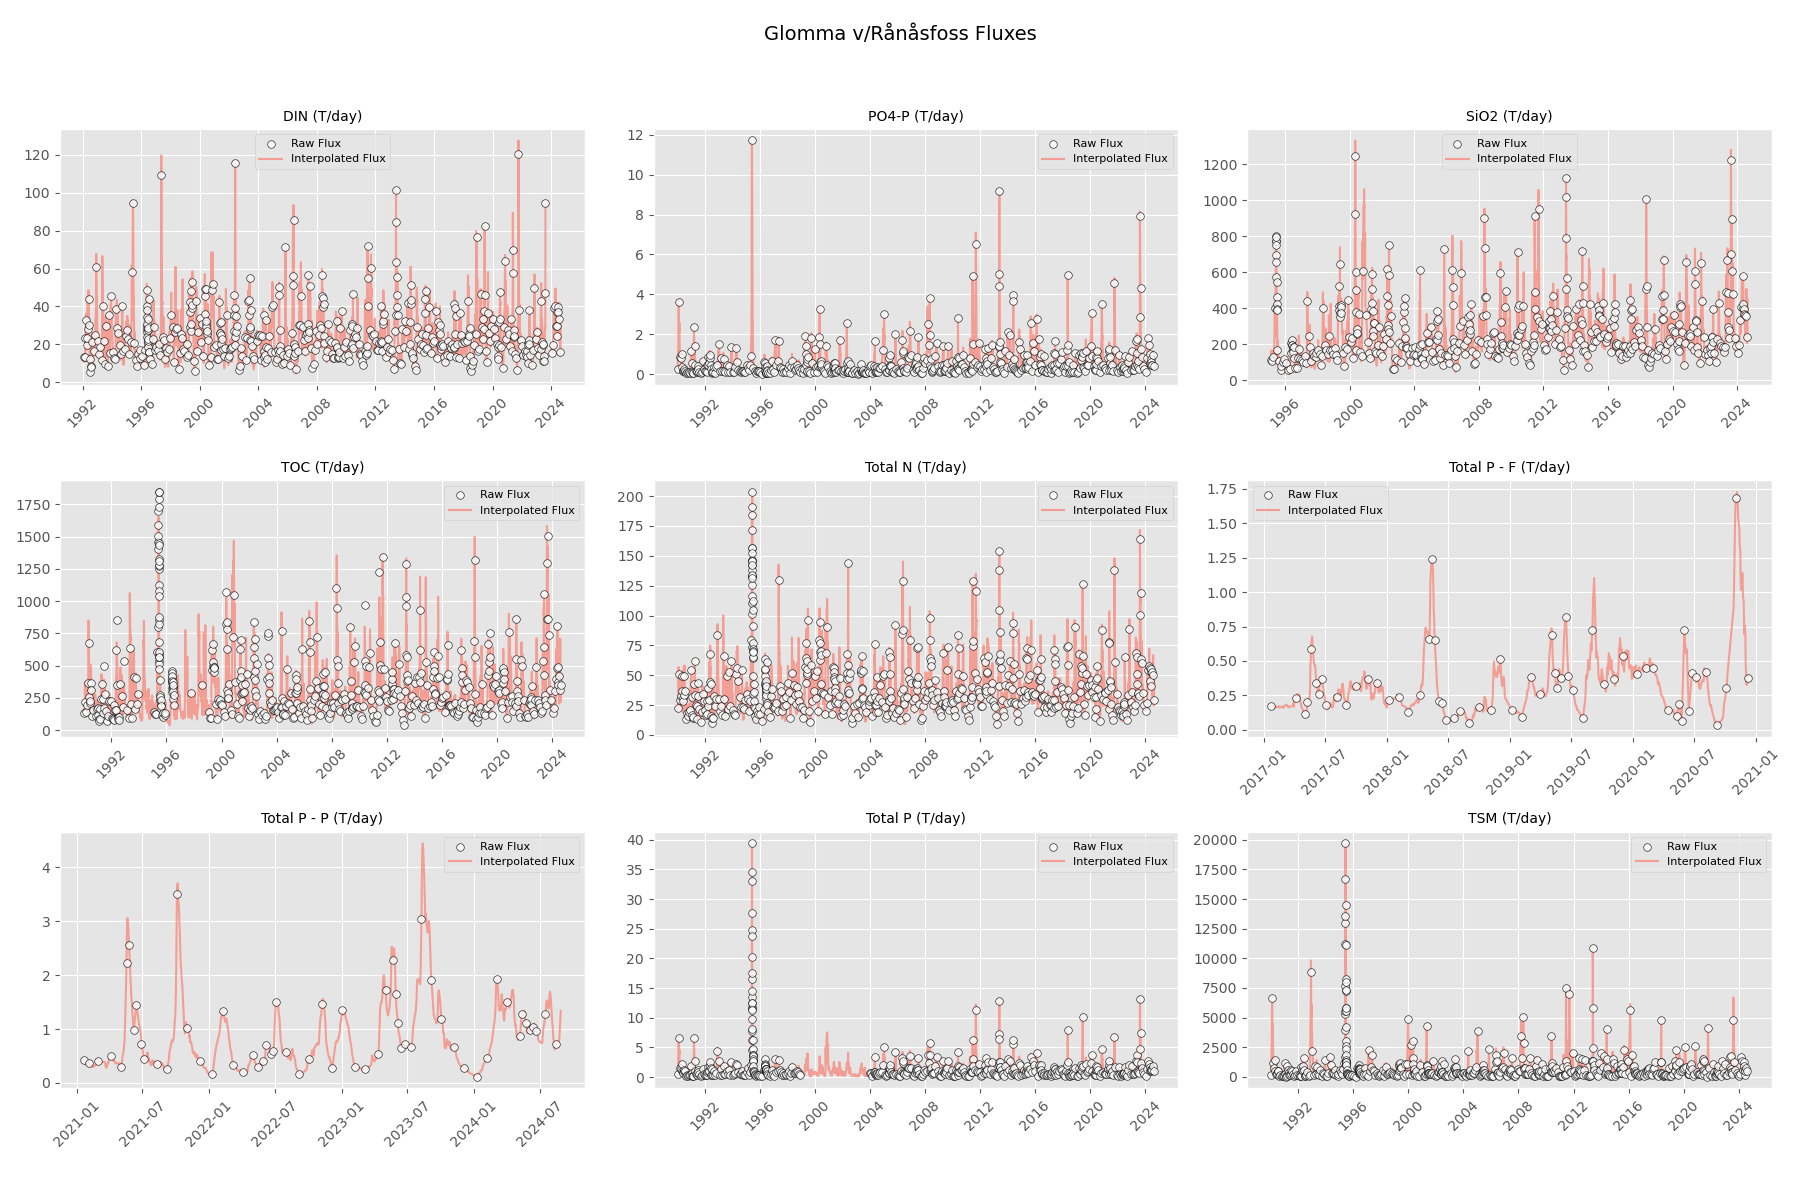

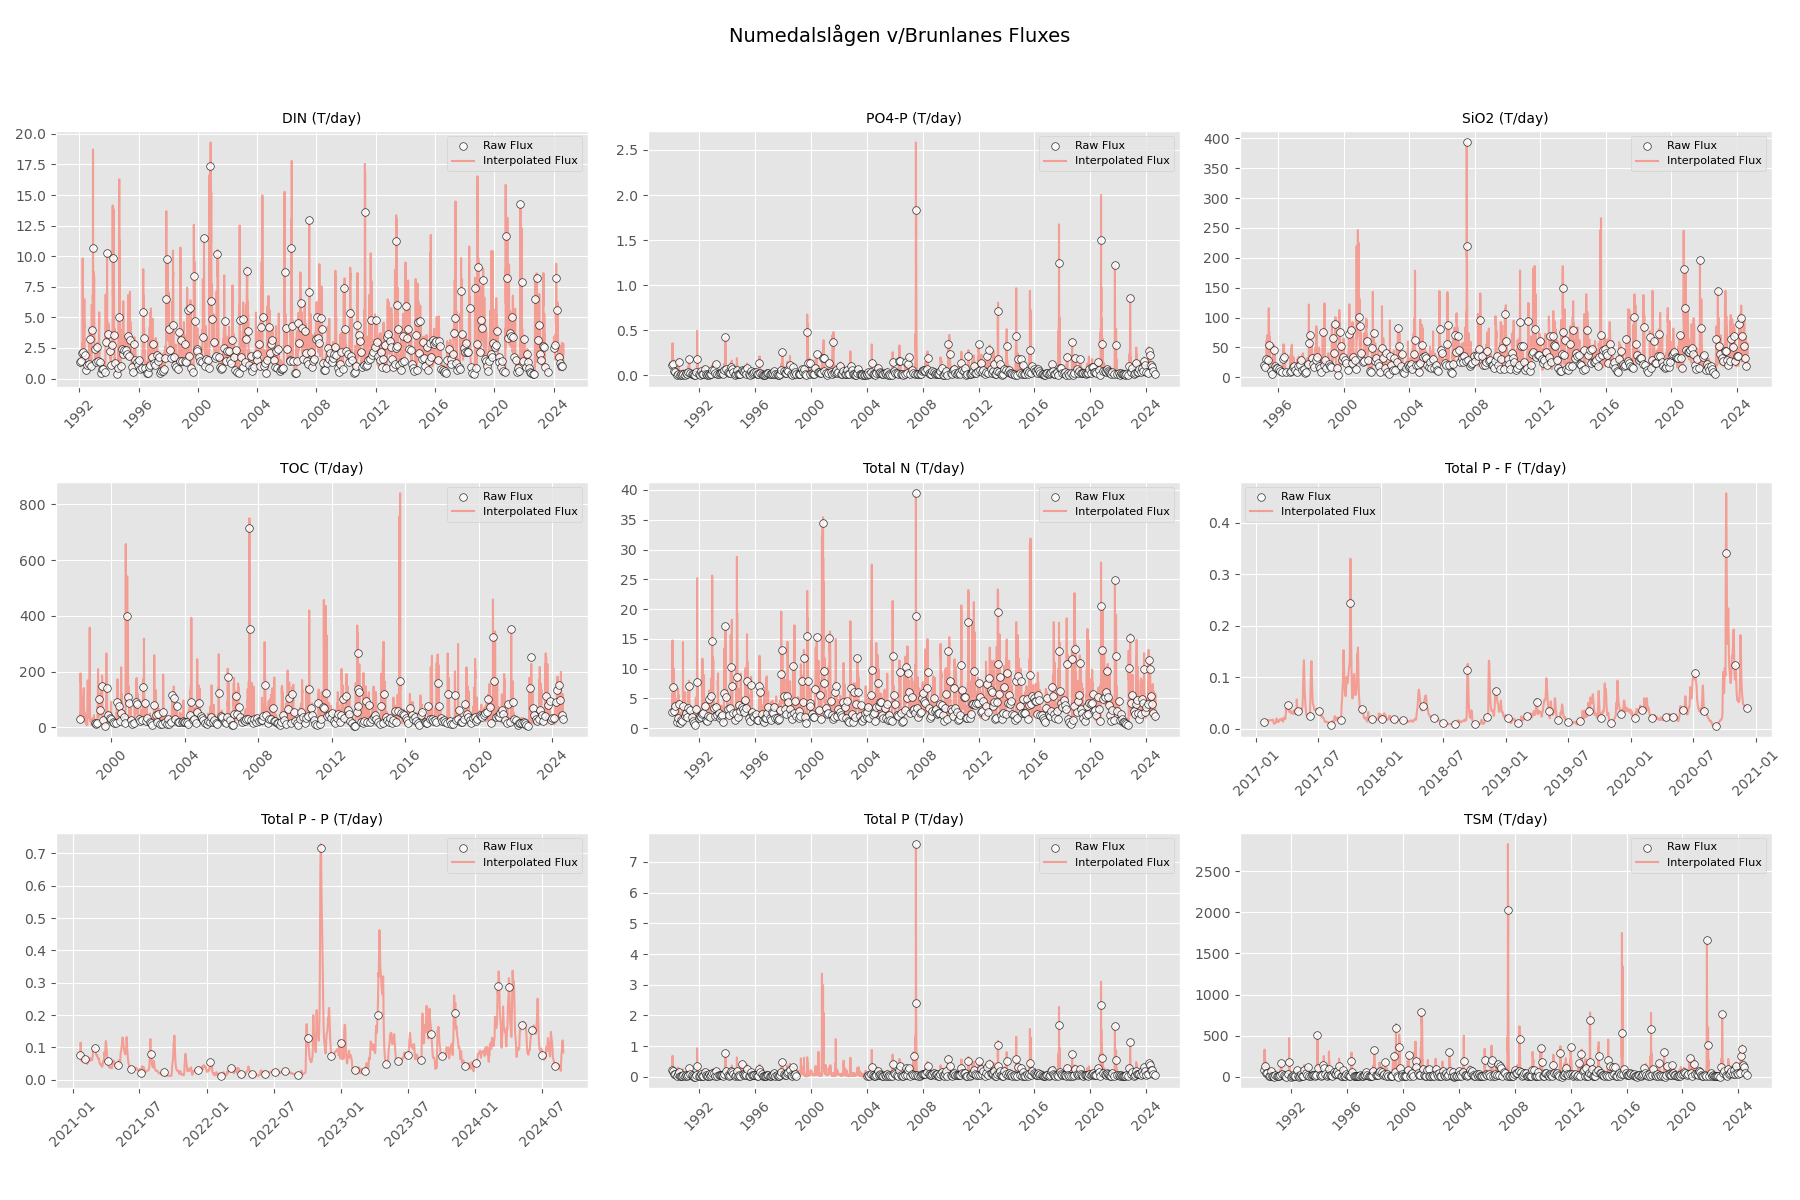

In [6]:
# Display names for axis labels
display_names = {
    'DIN_μg/l': 'DIN (T/day)',
    'PO4-P_µg/l': 'PO4-P (T/day)',
    'SiO2_mg/l': 'SiO2 (T/day)',
    'TOC_mg/l': 'TOC (T/day)',
    'TOTN_µg/l': 'Total N (T/day)',
    'TOTP/F_µg/l P': 'Total P - F (T/day)',
    'TOTP_P_µg/l P': 'Total P - P (T/day)',
    'TOTP_µg/l': 'Total P (T/day)',
    'TSM_mg/l': 'TSM (T/day)',
}

# Dictionary of your station DataFrames
station_dfs = {
    "Drammenselva v/Krokstadelva": drammen_fluxes,
    "Glomma v/Rånåsfoss": glomma_fluxes,
    "Numedalslågen v/Brunlanes": numed_fluxes
}

# Plot
for station_name, df_station in station_dfs.items():
   
    if 'Date' not in df_station.columns:
        df_station = df_station.reset_index()
    df_station['Date'] = pd.to_datetime(df_station['Date'])

    vars_to_plot = list(display_names.keys())
    n_vars = len(vars_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(vars_to_plot):
        ax = axes[i]

        raw_flux_col = f"{var}_raw_flux"
        proc_flux_col = f"{var}_est_flux"

        if raw_flux_col not in df_station.columns and proc_flux_col not in df_station.columns:
            continue 

        # Plot flux raw data 
        if raw_flux_col in df_station.columns:
            ax.scatter(df_station['Date'], df_station[raw_flux_col],
                       label='Raw Flux', marker='o', facecolors='white', edgecolors='black',
                       s=30, alpha=0.8, zorder=4)

        # Plot flux interpolated data 
        if proc_flux_col in df_station.columns:
            ax.plot(df_station['Date'], df_station[proc_flux_col],
                    label='Interpolated Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)


        ax.set_title(display_names.get(var, var), fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} Fluxes", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Monthly fluxes

In [8]:
drammen_fluxes['Date'] = pd.to_datetime(drammen_fluxes['Date']) 
drammen_fluxes.set_index('Date', inplace=True)
drammen_monthly_fluxes = drammen_fluxes.resample('ME').sum(min_count=1)  #in_count=1 means: require at least one non-NaN to compute the sum — otherwise, return NaN.


glomma_fluxes['Date'] = pd.to_datetime(glomma_fluxes['Date']) 
glomma_fluxes.set_index('Date', inplace=True)
glomma_monthly_fluxes = glomma_fluxes.resample('ME').sum(min_count=1) 


numed_fluxes['Date'] = pd.to_datetime(numed_fluxes['Date'])  
numed_fluxes.set_index('Date', inplace=True)
numed_monthly_fluxes = numed_fluxes.resample('ME').sum(min_count=1) 

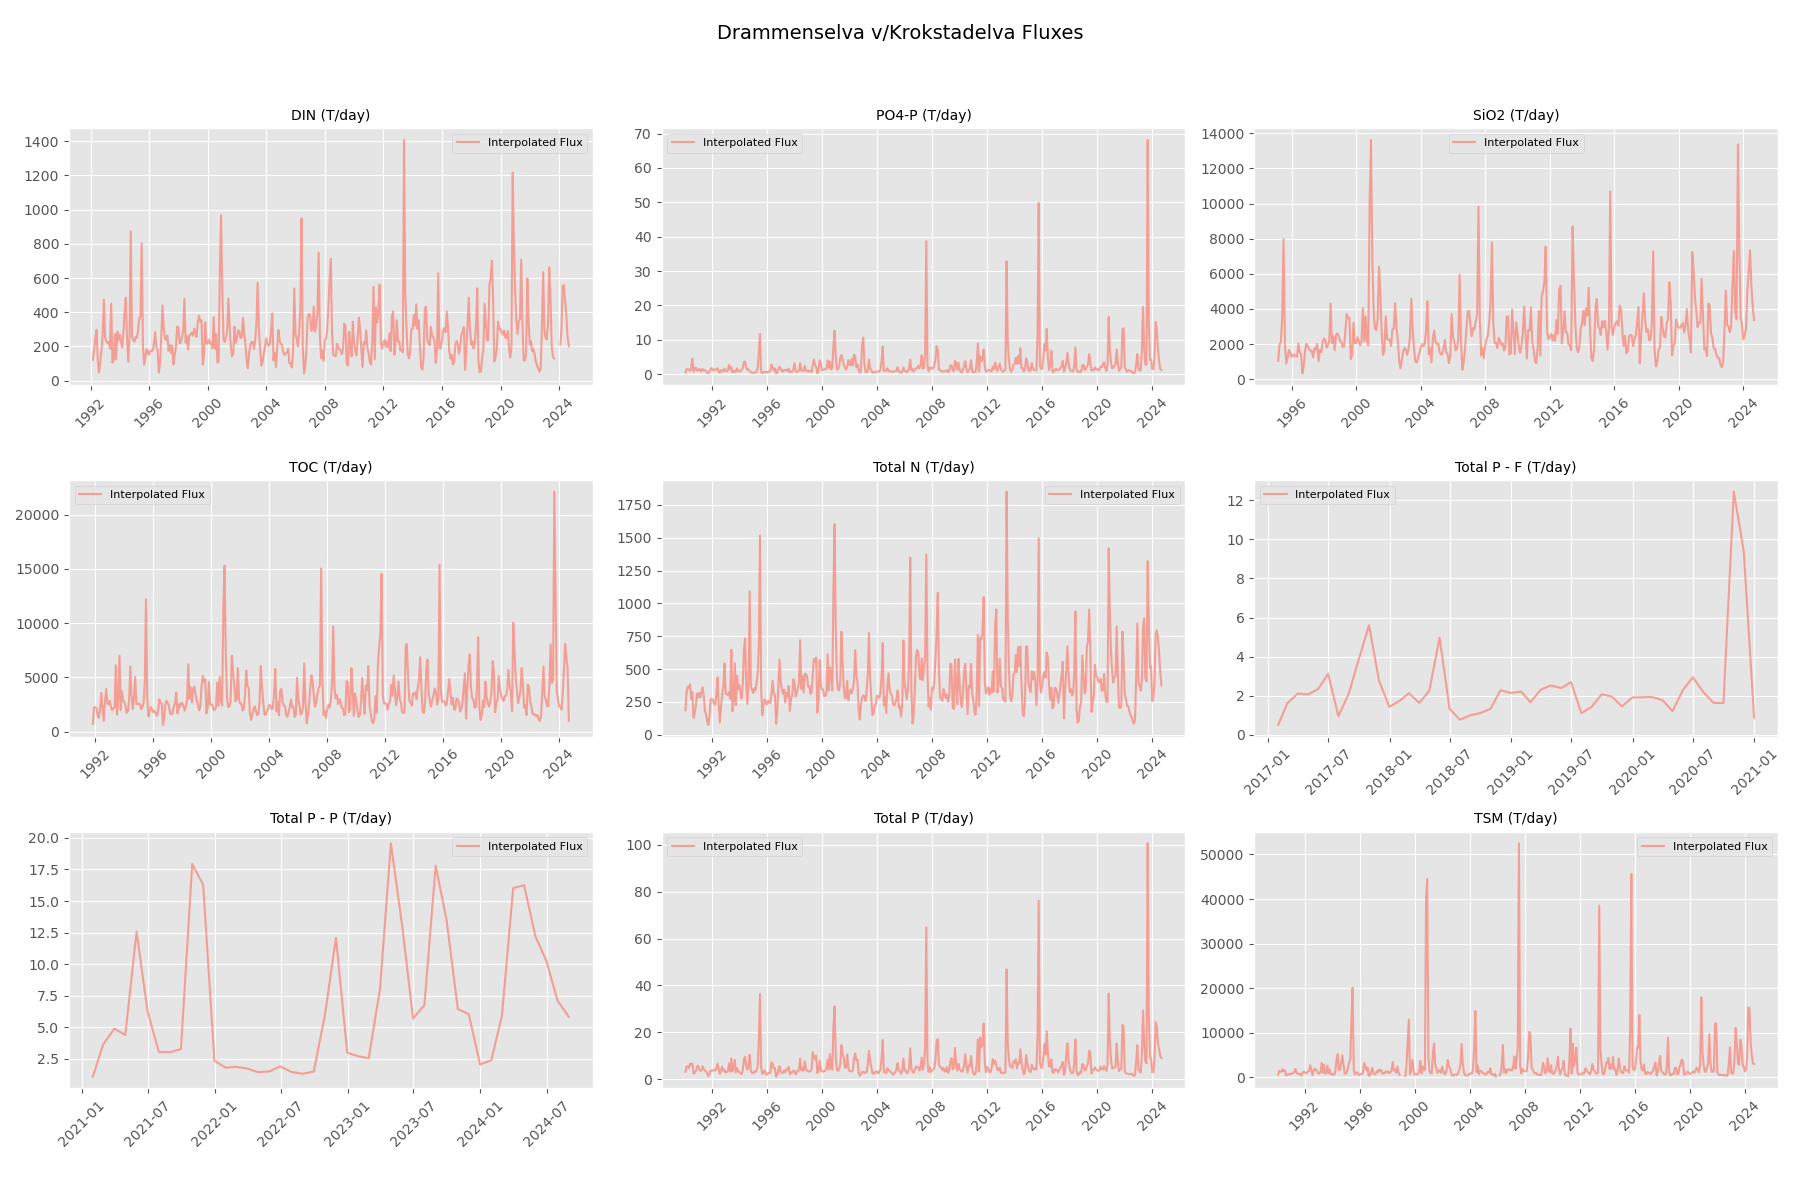

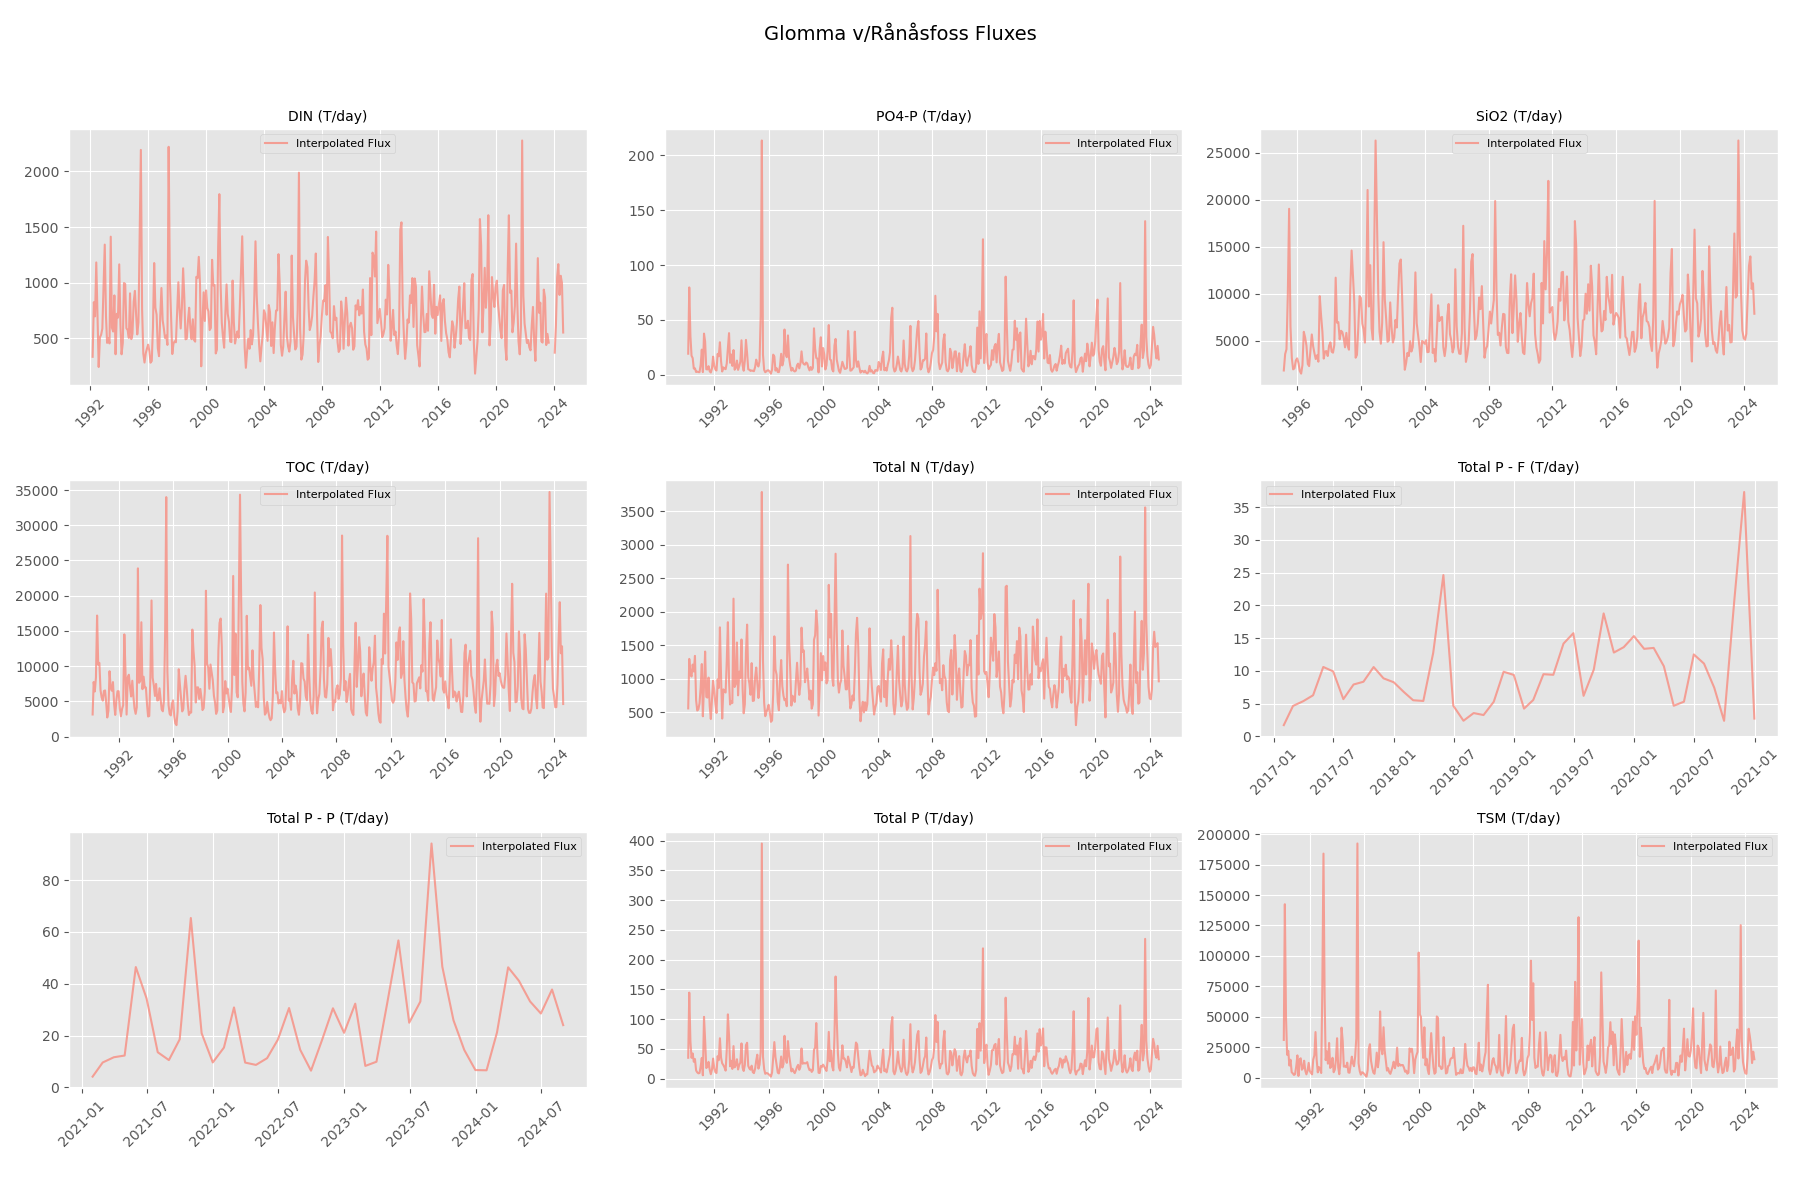

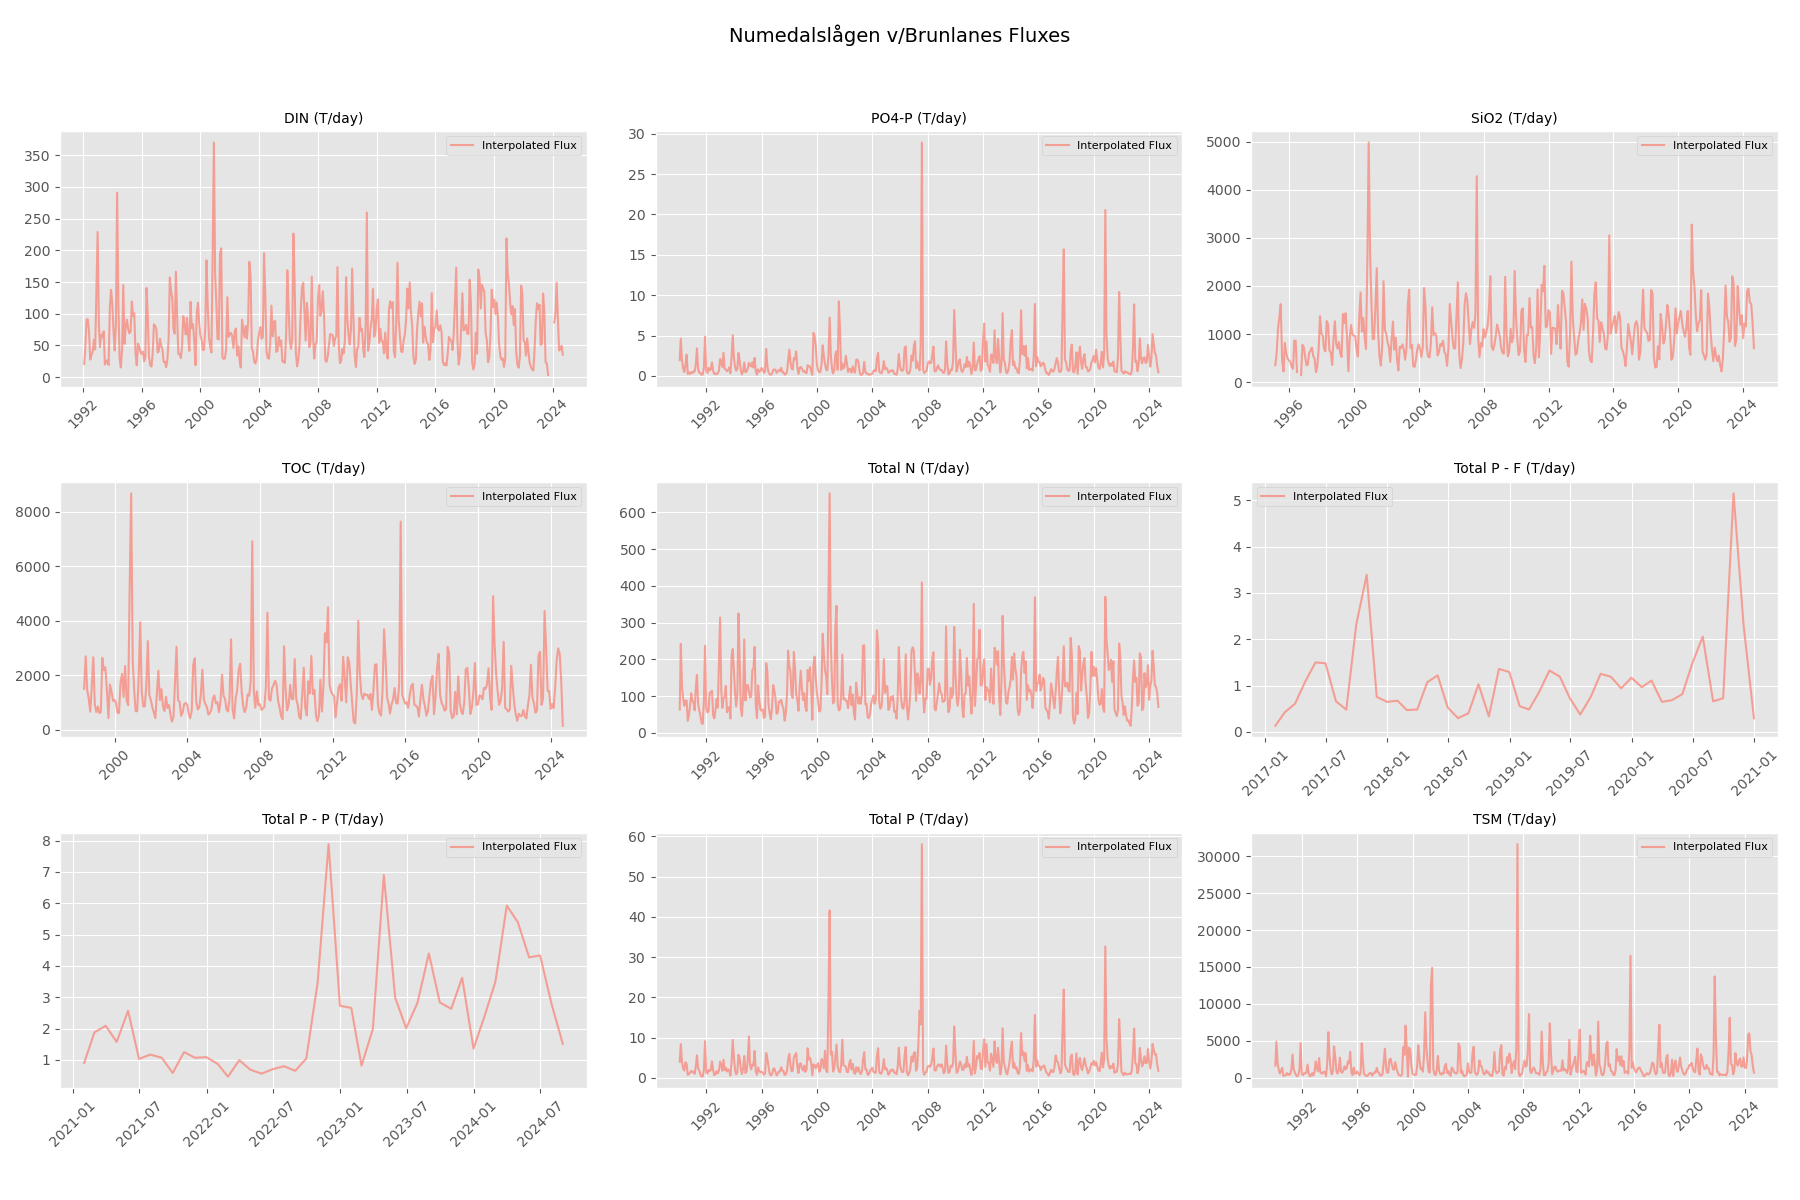

In [12]:
# Dictionary of your station DataFrames
station_dfs = {
    "Drammenselva v/Krokstadelva": drammen_monthly_fluxes,
    "Glomma v/Rånåsfoss": glomma_monthly_fluxes,
    "Numedalslågen v/Brunlanes": numed_monthly_fluxes
}

for station_name, df_station in station_dfs.items():
    
    if 'Date' not in df_station.columns:
        df_station = df_station.reset_index()
    df_station['Date'] = pd.to_datetime(df_station['Date'])

    vars_to_plot = list(display_names.keys())
    n_vars = len(vars_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        
        proc_flux_col = f"{var}_est_flux"

        if raw_flux_col not in df_station.columns and proc_flux_col not in df_station.columns:
            continue  

        if proc_flux_col in df_station.columns:
            ax.plot(df_station['Date'], df_station[proc_flux_col],
                    label='Interpolated Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)

        # Set title and labels
        ax.set_title(display_names.get(var, var), fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} Fluxes", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Annual fluxes

In [10]:
# Compute the fluxes and print the result
drammen_annual_fluxes = drammen_fluxes.resample('YE').sum(min_count=1)  #in_count=1 means: require at least one non-NaN to compute the sum — otherwise, return NaN.
glomma_annual_fluxes = glomma_fluxes.resample('YE').sum(min_count=1) 
numed_annual_fluxes = numed_fluxes.resample('YE').sum(min_count=1) 

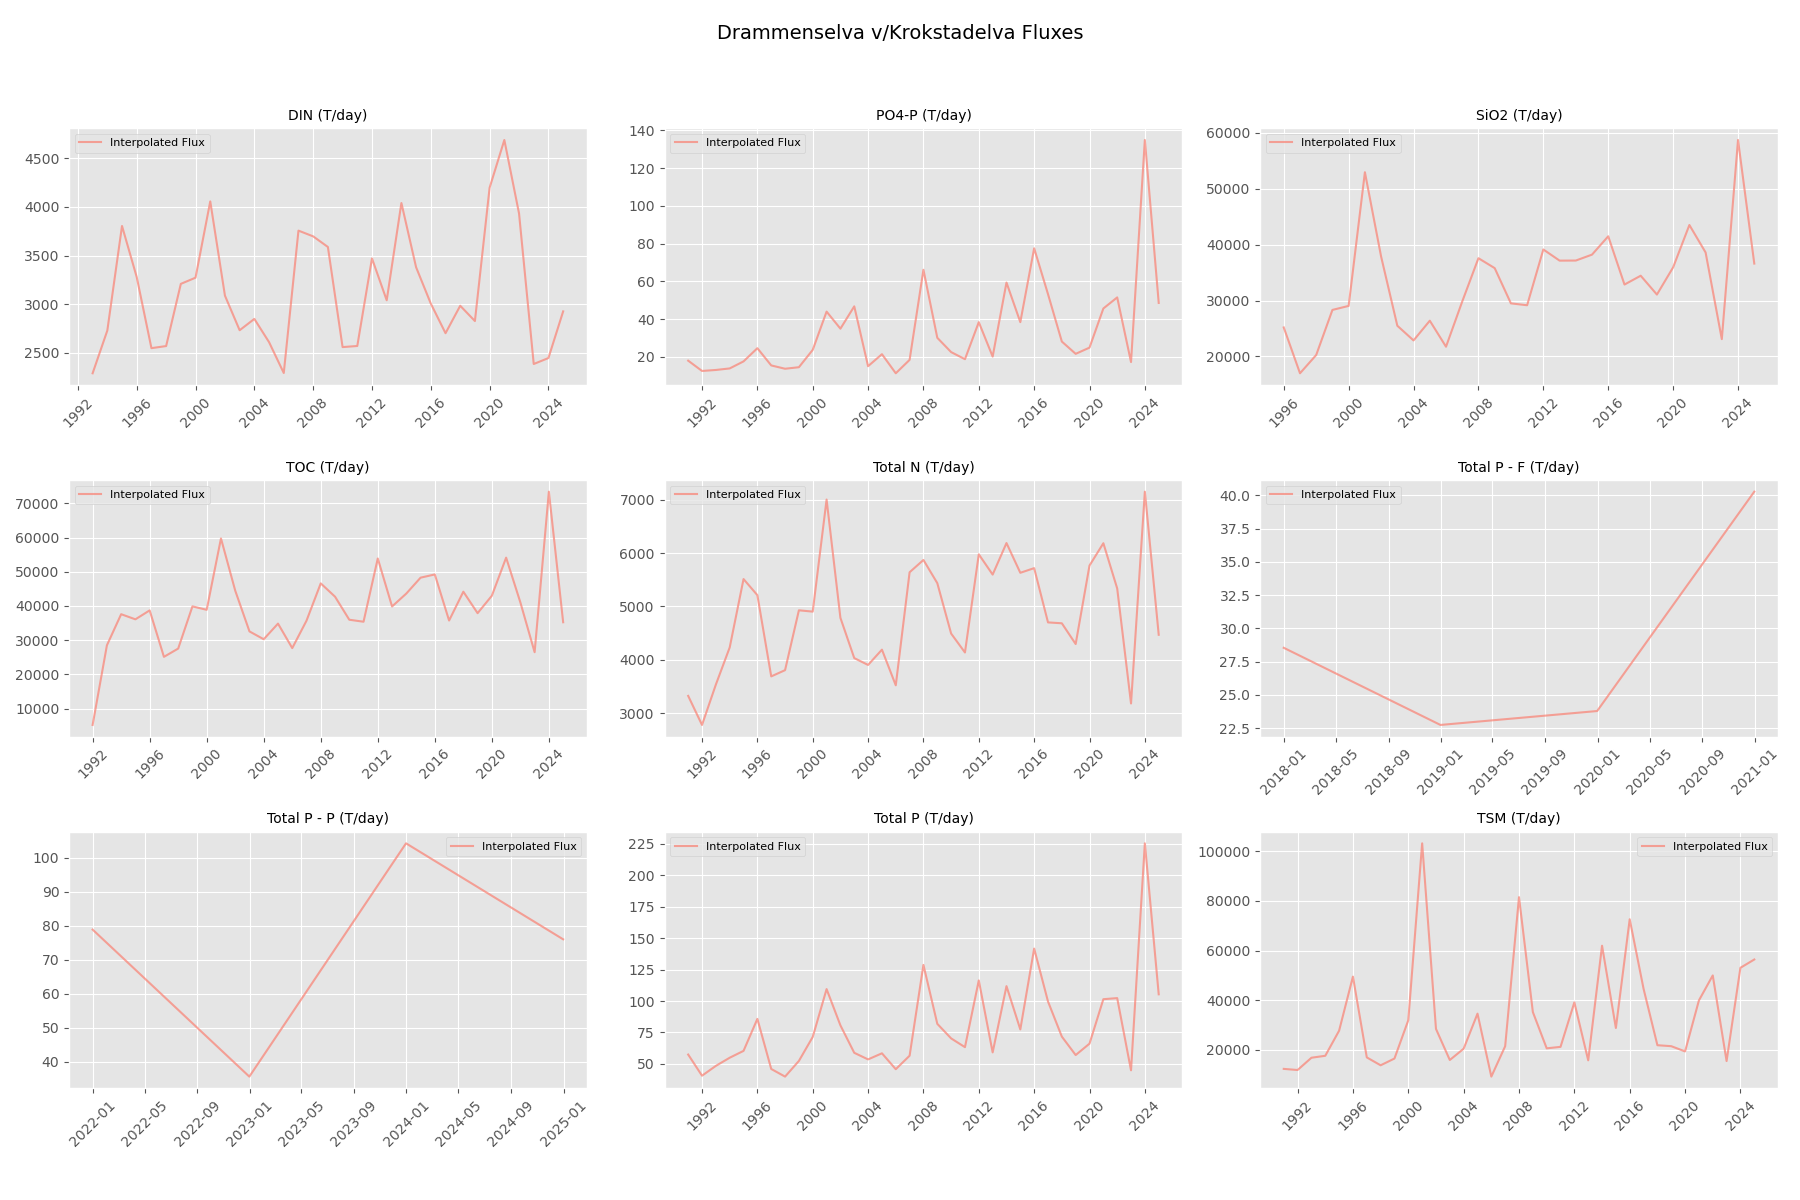

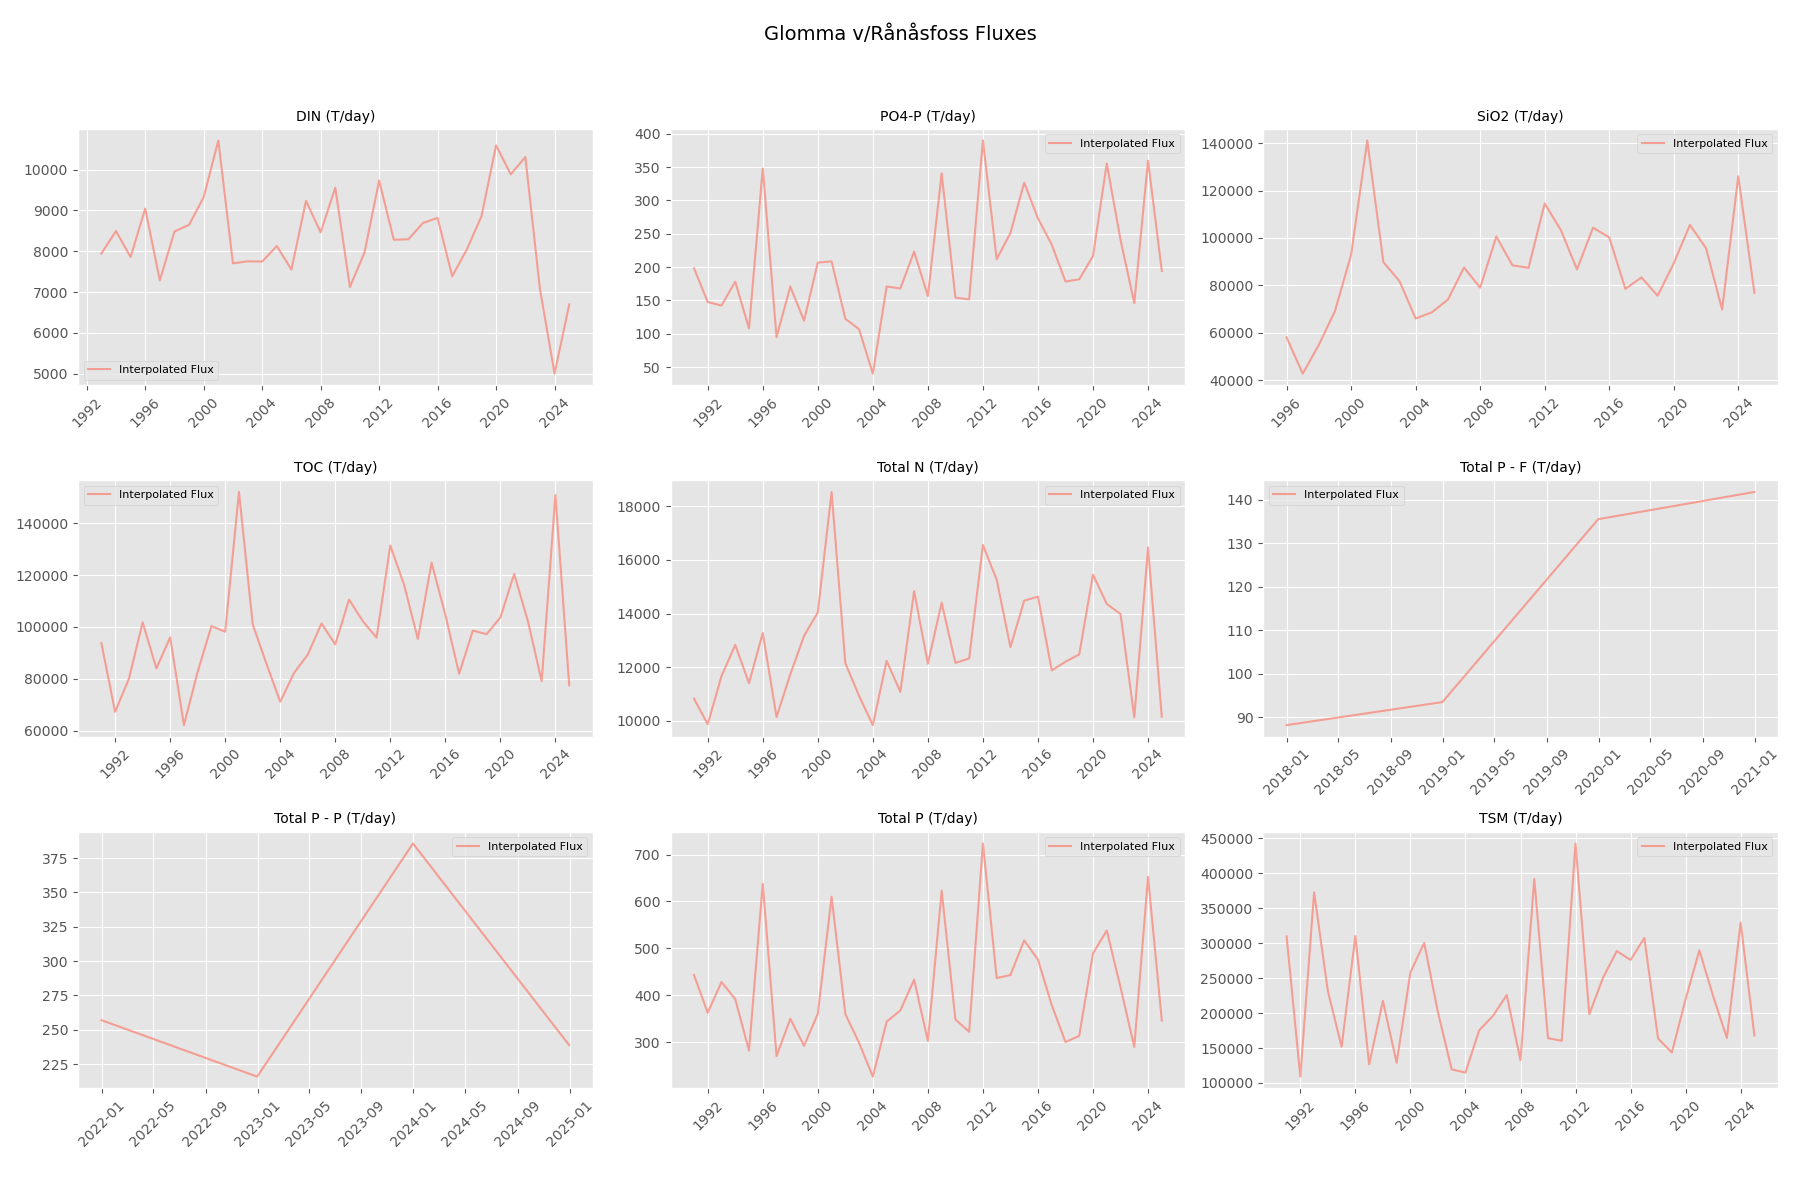

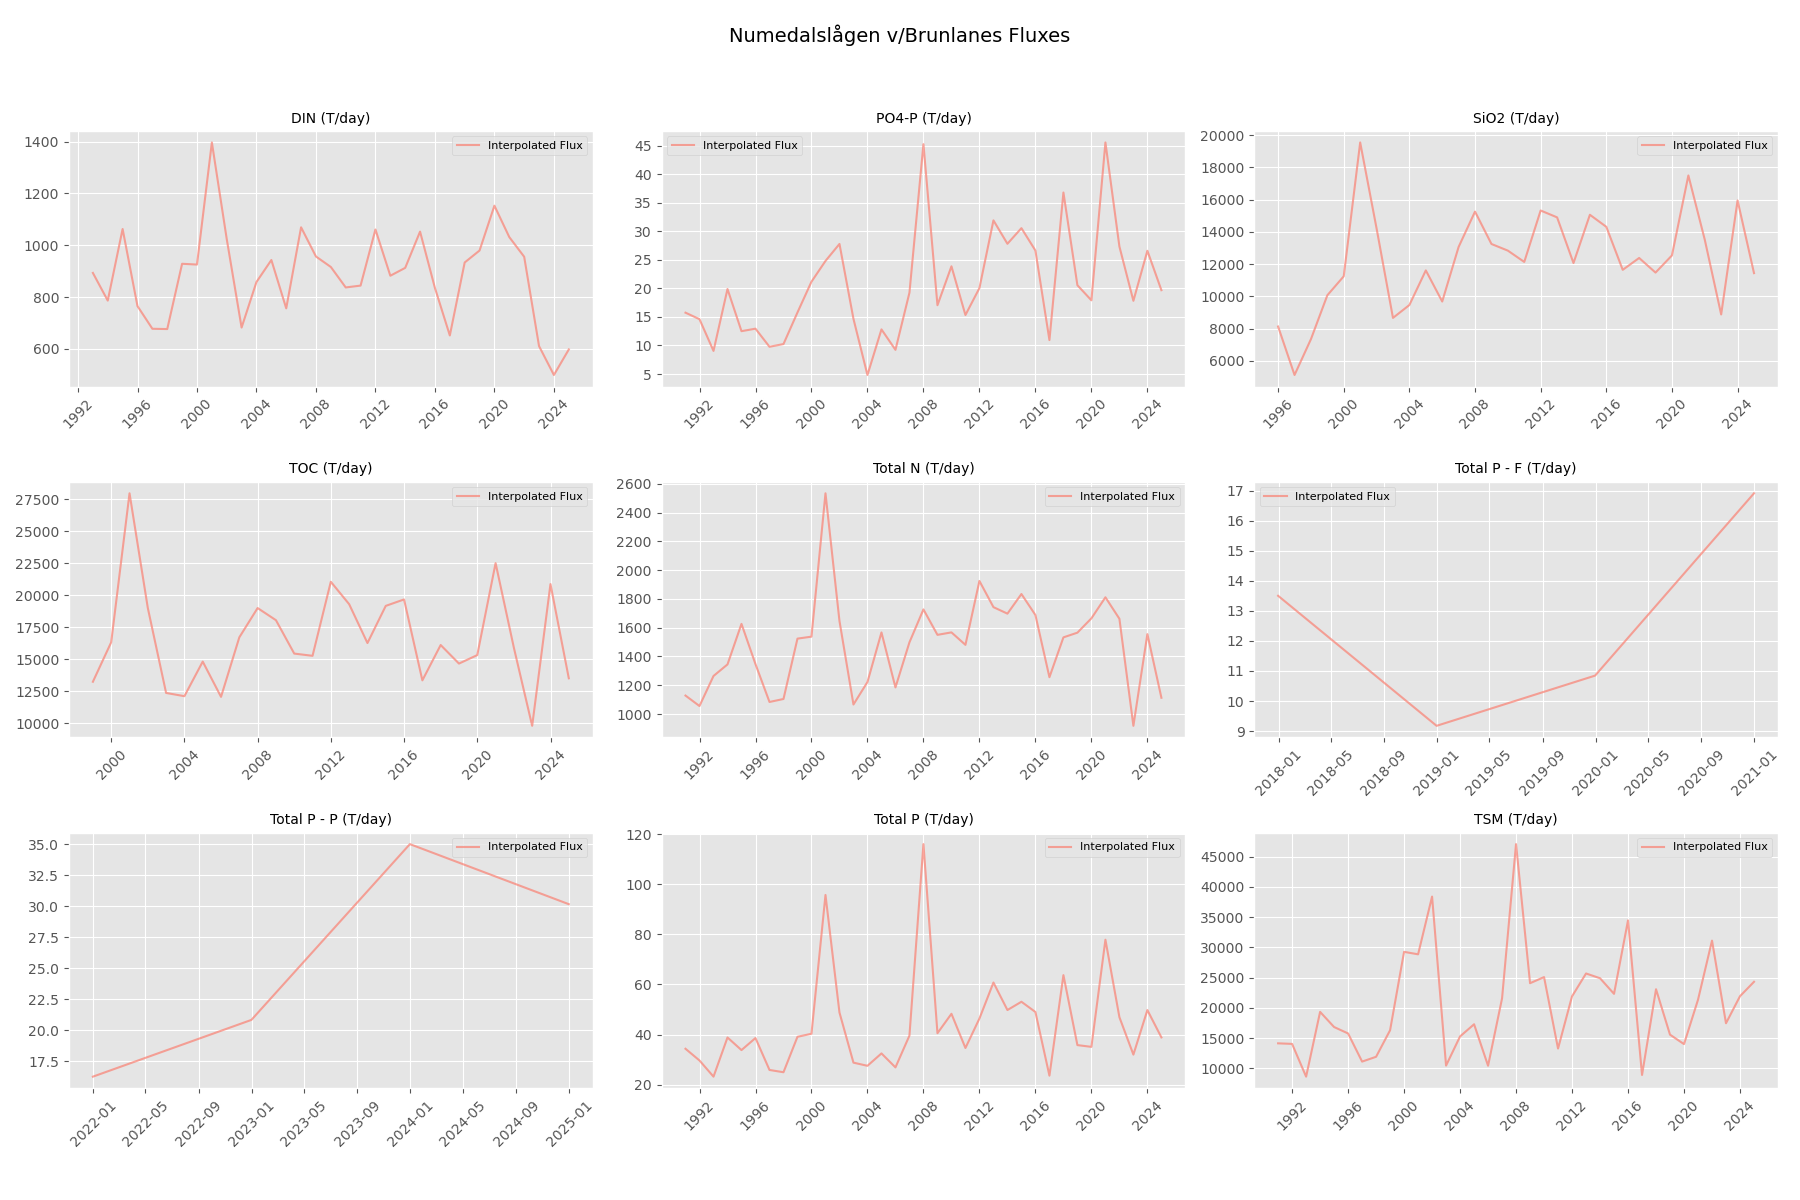

In [13]:
# Dictionary of your station DataFrames
station_dfs = {
    "Drammenselva v/Krokstadelva": drammen_annual_fluxes,
    "Glomma v/Rånåsfoss": glomma_annual_fluxes,
    "Numedalslågen v/Brunlanes": numed_annual_fluxes
}

for station_name, df_station in station_dfs.items():
    if 'Date' not in df_station.columns:
        df_station = df_station.reset_index()
    df_station['Date'] = pd.to_datetime(df_station['Date'])

    vars_to_plot = list(display_names.keys())
    n_vars = len(vars_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(vars_to_plot):
        ax = axes[i]

        proc_flux_col = f"{var}_est_flux"

        if raw_flux_col not in df_station.columns and proc_flux_col not in df_station.columns:
            continue 

        if proc_flux_col in df_station.columns:
            ax.plot(df_station['Date'], df_station[proc_flux_col],
                    label='Interpolated Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)

        # Set title and labels
        ax.set_title(display_names.get(var, var), fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} Fluxes", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
